In [16]:
from abc import ABC, abstractmethod
from collections import deque
import numpy as np
import matplotlib.pyplot as plt

class Equation():

    input_nodes = []
    output_nodes = []

    topological_order = []
    reverse_topological_order = []

    def __init__(self, inputs, outputs) -> None:
        self.input_nodes = inputs
        self.output_nodes = outputs

        self.topological_order = []
        for output in outputs:
            self.__rec_make_topo_order(output, set())
        
        self.reverse_topological_order = [t for t in self.topological_order]
        self.reverse_topological_order.reverse()

    def __rec_make_topo_order(self, to_search, seen_nodes):
        
        for source in to_search.sources:

            if source not in seen_nodes:
                seen_nodes.add(source)
                self.__rec_make_topo_order(source, seen_nodes)
            
        self.topological_order.append(to_search)

    def forwards(self, inputs) -> float:

        for node in self.topological_order:
            node.run(inputs)

        return [output_node.result for output_node in self.output_nodes]
    
    def backwards_from_last_forwards(self):

        for node in self.topological_order:
            node.clear_gradient()

        for output_node in self.output_nodes:
            output_node.gradient = 1
        
        for node in self.reverse_topological_order:
            node.propagate_gradient()

        return [inp.gradient for inp in self.input_nodes]
    
    def check(self, x):

        v = np.random.randn(len(x))

        max_iters = 32
        h = np.zeros(max_iters)
        err0 = np.zeros(max_iters)
        err1 = np.zeros(max_iters)

        for i in range(max_iters):
            h[i] = 2**(-i) # halve our stepsize every time

            fv = np.array(self.forwards(x + h[i]*v))

            T0 = np.array(self.forwards(x))
            T0_grad = np.array(self.backwards_from_last_forwards())

            T1 = T0 + h[i]*np.matmul(T0_grad.transpose(), v)

            err0[i] = np.linalg.norm(fv - T0) # this error should be linear
            err1[i] = np.linalg.norm(fv - T1) # this error should be quadratic

            # print('h = ', h, ', err0 = ', err0[i], ', err1 = ', err1[i])

            #print('h: %.3e, \t err0: %.3e, \t err1: %.3e' % (h[i], err0[i], err1[i]))

        plt.loglog(h, err0, linewidth=3)
        plt.loglog(h, err1, linewidth=3)
        plt.legend(['$\|f(x) - T_0(x)\|$', '$\|f(x)-T_1(x)\|$'], fontsize=15)
        plt.xticks(fontsize=15)
        plt.yticks(fontsize=15)

class AbstractOperationNode(ABC):

    sources = []
    listeners = []

    result: float
    gradient: float

    def __init__(self, *args) -> None:

        for source in args:
            source.listeners.append(source)

        self.sources = args
        self.listeners = []

        super().__init__()

    def run(self, inputs):
        self.result = self.inner_run(inputs)

    def clear_gradient(self):
        self.gradient = 0

    def to_equation(self):
        return Equation(self.find_variable_node_dependencies(), [self])

    def find_variable_node_dependencies(self):
        variables = []
        searched = [self]
        to_search = deque()
        to_search.append(self)

        # if this fails to terminate, you probably have a dependency loop
        while len(to_search) > 0:
            next_search = to_search.popleft()
            
            if next_search.is_variable():
                variables.append(next_search)
            else:
                for source in next_search.sources:
                    if source not in searched:
                        to_search.append(source)
                        searched.append(source)

        variables.sort()
        return variables

    @abstractmethod
    def inner_run(self, inputs) -> float:
        pass

    @abstractmethod
    def propagate_gradient(self): # assume that grad is completely setup
        pass

    @abstractmethod
    def __str__(self) -> str:
        return ""
    
    def is_variable(self) -> bool:
        return False

class Const(AbstractOperationNode):

    c: float

    def __init__(self, c: float):
        super().__init__()
        self.c = c

    def inner_run(self, inputs) -> float:
        return self.c

    def propagate_gradient(self): # assume that grad is completely setup
        pass
    
    def __str__(self) -> str:
        return str(self.c)

class Variable(AbstractOperationNode):

    input_index: int

    def __init__(self, input_index) -> None:
        super().__init__()
        self.input_index = input_index

    def inner_run(self, inputs) -> float:
        return inputs[self.input_index]

    def propagate_gradient(self): # assume that grad is completely setup
        pass
    
    def __str__(self) -> str:
        return "[" + str(self.input_index) + "]"
    
    def __lt__(self, other):
        return self.input_index < other.input_index
    
    def is_variable(self) -> bool:
        return True

class Add(AbstractOperationNode):

    def __init__(self, a: AbstractOperationNode, b: AbstractOperationNode):
        super().__init__(a, b)

    def inner_run(self, inputs) -> float:
        return self.sources[0].result + self.sources[1].result

    def propagate_gradient(self): # assume that grad is completely setup
        self.sources[0].gradient += self.gradient
        self.sources[1].gradient += self.gradient

    def __str__(self) -> str:
        return "(" + str(self.sources[0]) + " + " + str(self.sources[1]) + ")"

class Mult(AbstractOperationNode):

    def __init__(self, a: AbstractOperationNode, b: AbstractOperationNode):
        super().__init__(a, b)

    def inner_run(self, inputs) -> float:
        return self.sources[0].result * self.sources[1].result

    def propagate_gradient(self): # assume that grad is completely setup
        self.sources[0].gradient += self.sources[1].result * self.gradient
        self.sources[1].gradient += self.sources[0].result * self.gradient
    
    def __str__(self) -> str:
        return "(" + str(self.sources[0]) + " * " + str(self.sources[1]) + ")"
        


[10]
[7, 2]


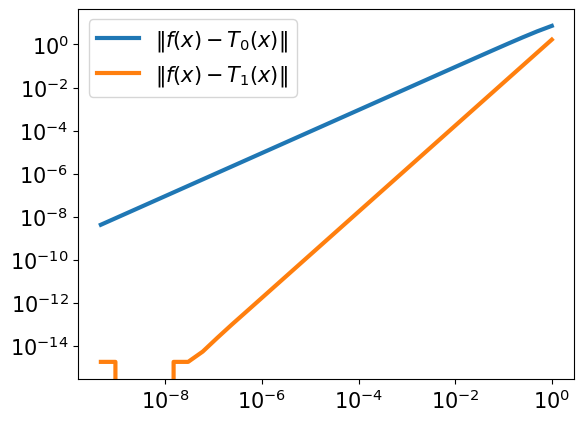

In [17]:
x = Variable(0)
y = Variable(1)
x_mult = Mult(x, x)
xy_mult = Mult(x, y)
add = Add(x_mult, xy_mult)

eqn = add.to_equation()
print(eqn.forwards([2, 3]))
print(eqn.backwards_from_last_forwards())

eqn.check([2,3])

In [19]:
import numpy as np

class Tanh(AbstractOperationNode):

    def __init__(self, a: AbstractOperationNode):
        super().__init__(a)

    def inner_run(self, inputs) -> float:
        return np.tanh(self.sources[0].result)
    
    def propagate_gradient(self): # assume that grad is completely setup
        self.sources[0].gradient += (1 - np.tanh(self.sources[0].result)**2) * self.gradient
    
    def __str__(self) -> str:
        return "tanh(" + str(self.a) + ")"

[0.7615941559557649]
[0.41997434161402614]


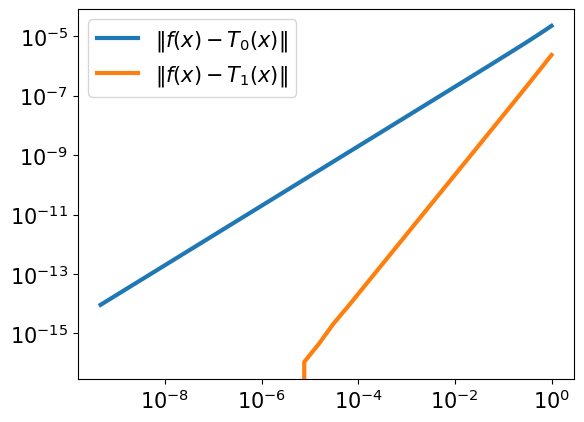

In [21]:
x = Variable(0)
f1 = Tanh(x)

eqn = f1.to_equation()
print(eqn.forwards([1]))
print(eqn.backwards_from_last_forwards())

eqn.check([5])

[0.7615941559557649]
[0.8399486832280523]


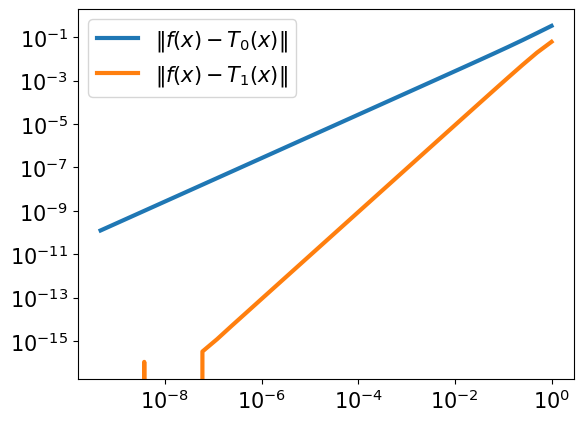

In [25]:
x = Variable(0)
f1 = Tanh(Mult(x, x))

eqn = f1.to_equation()
print(eqn.forwards([1]))
print(eqn.backwards_from_last_forwards())

eqn.check([1])

[0.9999999999244973]
[1.510054303821562e-10]


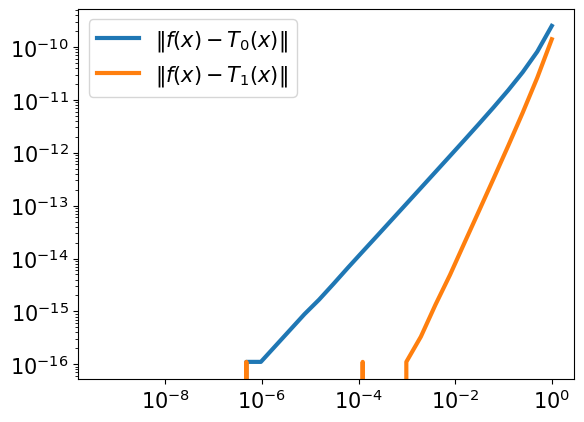

In [27]:
x = Variable(0)

f1 = Tanh(Add(Mult(Const(1), x), Const(2)))

eqn = f1.to_equation()
print(eqn.forwards([10]))
print(eqn.backwards_from_last_forwards())

eqn.check([10])

[array([-0.22805921])]
[array([-1.16805633]), array([0.947989])]


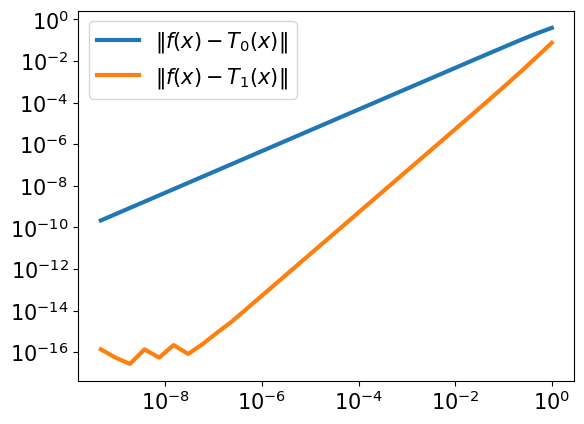

In [29]:
x = np.random.randn(1)
expected = np.random.randn(1)

w = Variable(0)
b = Variable(1)

f1 = Tanh(Add(Mult(w, Const(x)), b))

eqn = f1.to_equation()
print(eqn.forwards([1, 1]))
print(eqn.backwards_from_last_forwards())

eqn.check([1, 1])

In [30]:
class Div(AbstractOperationNode):

    def __init__(self, a: AbstractOperationNode, b: AbstractOperationNode):
        super().__init__(a, b)

    def inner_run(self, inputs) -> float:
        return self.sources[0].result / self.sources[1].result

    def propagate_gradient(self): # assume that grad is completely setup
        self.sources[0].gradient += self.gradient / self.sources[1].result
        self.sources[1].gradient += (-self.gradient * self.sources[0].result / (self.sources[1].result * self.sources[1].result))
    
    def __str__(self) -> str:
        return "(" + str(self.sources[0]) + " / " + str(self.sources[1]) + ")"

[0.46211715726000974]
[0.3932238664829637, -0.19661193324148185]


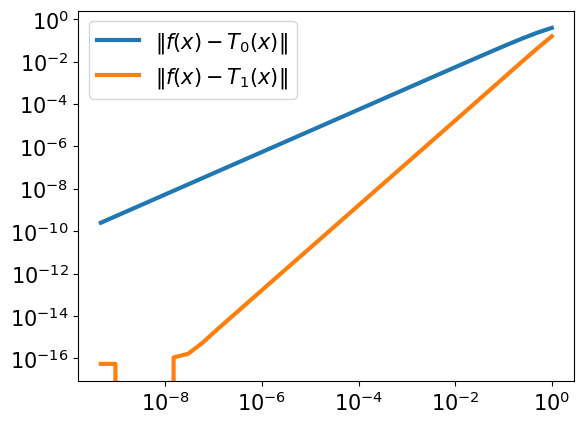

In [32]:
x = Variable(0)
y = Variable(1)
f1 = Tanh(Div(x, y))

eqn = f1.to_equation()
print(eqn.forwards([1, 2]))
print(eqn.backwards_from_last_forwards())

eqn.check([1, 2])